# A first principles-based iterative method for longitudinal trajectories smoothing and correction

# Introduction
In this paper, we introduce three first principles for smoothing and correcting longitudinal vehicle trajectory data: (P1) internal consistency among variables at different orders, satisfying both differentiation and integration relations; (P2) bounded speeds, accelerations, and jerks; (P3) minimizing the mean absolute errors (MAEs) in the raw positions. 
Based on the first principles, we propose an iterative method for smoothing and correcting longitudinal vehicle trajectory data. One iteration comprises four types of calculations: differentiation, correction, smoothing, and integration.
In differentiation, we compute speeds, accelerations, and jerks from positions; in correction, we eliminate outliers in speeds, especially negative values; in smoothing, we reduce noises in accelerations and jerks; and in integration, we recalculate accelerations, speeds, and positions from jerks, and find the initial values by solving optimization problems. 

# Upload the data
First we need to upload the raw data we want to process

In [ ]:
import micropip
 
package_url = "https://raw.githubusercontent.com/innovationOUtside/ouseful_jupyterlite_utils/main/ouseful_jupyterlite_utils-0.0.1-py3-none-any.whl"
 
await micropip.install(package_url)

## Pick out the columns
We first import some packages we may use throughout all modules. We then pick out the columns we may use or take as references according to their labels.


In [ ]:
import pandas as pd
import io
import numpy as np
import scipy
from scipy.interpolate import CubicSpline
from ouseful_jupyterlite_utils import pandas_utils as pdu
 
#include different correction methods, filters and optimization functions
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)#3 digit, no scientific notation
np.set_printoptions(threshold=np.inf) #no ellipses
veh_traj = pd.read_csv('veh973.csv', usecols = ['Vehicle_ID','Frame_ID','Global_Time','Local_X','Local_Y','v_Vel','v_Acc','v_Length','Int_ID','Section_ID','Direction','Movement','Preceding','Space_Headway'])

## Change the units and add new columns to store smoothed and corrected data
In the proposed framework, we consider the units of the position and speed to be $m$ and $m/s$, respectively. However, the units in the raw data are $ft$ and $ft/s$. Thus we need to change the units first according to $1ft=0.3048m$. <br>
Meanwhile, we add colunms at the end to store the calculated and processed position, speed, acceleration, and jerk.

In [ ]:
def change_unit(veh_traj1):
    ft_to_m = 0.3048 # change the unit: from ft to m
    #change time to second
    veh_traj1['Global_Time'] = veh_traj1['Global_Time'] * 0.001
    for item in ['Local_X','Local_Y','v_Vel','v_Acc']:
        veh_traj1[item] = veh_traj1[item]*0.3048
    #add 8 columns at the end, called "distance", "velocity", "acceleration", and "jerk"
    veh_traj1['distance'] = 0
    veh_traj1['velocity'] = 0
    veh_traj1['acceleration'] = 0 
    veh_traj1['jerk'] = 0 
    veh_traj1['smooth_x'] = 0
    veh_traj1['smooth_v'] = 0
    veh_traj1['smooth_a'] = 0
    veh_traj1['smooth_j'] = 0
    return veh_traj1

#the data that can be used
veh_unit = change_unit(veh_traj)
veh_unit

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Length,v_Vel,v_Acc,Int_ID,Section_ID,...,Preceding,Space_Headway,distance,velocity,acceleration,jerk,smooth_x,smooth_v,smooth_a,smooth_j
0,973,6747,1118940000.000,4.980,10.116,15.500,8.769,0.000,1,0,...,967,86.310,0,0,0,0,0,0,0,0
1,973,6748,1118940000.000,4.994,10.851,15.500,8.769,0.000,1,0,...,967,86.440,0,0,0,0,0,0,0,0
2,973,6749,1118940000.000,5.030,11.765,15.500,8.769,0.000,1,0,...,967,85.940,0,0,0,0,0,0,0,0
3,973,6750,1118940000.000,5.065,12.679,15.500,8.769,0.000,1,0,...,967,85.430,0,0,0,0,0,0,0,0
4,973,6751,1118940000.000,5.100,13.592,15.500,8.769,0.000,1,0,...,967,84.890,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,973,7779,1118940000.000,16.038,487.037,15.500,3.185,3.325,0,5,...,0,0.000,0,0,0,0,0,0,0,0
1033,973,7780,1118940000.000,16.087,487.472,15.500,5.535,2.941,0,5,...,0,0.000,0,0,0,0,0,0,0,0
1034,973,7781,1118940000.000,16.152,488.027,15.500,5.535,0.000,0,5,...,0,0.000,0,0,0,0,0,0,0,0
1035,973,7782,1118940000.000,16.081,488.913,15.500,5.535,0.000,0,5,...,0,0.000,0,0,0,0,0,0,0,0


# Longitudinal vehicle trajectories correction and smoothing
The entire framwork we propose is shown as figure 2 in the paper.

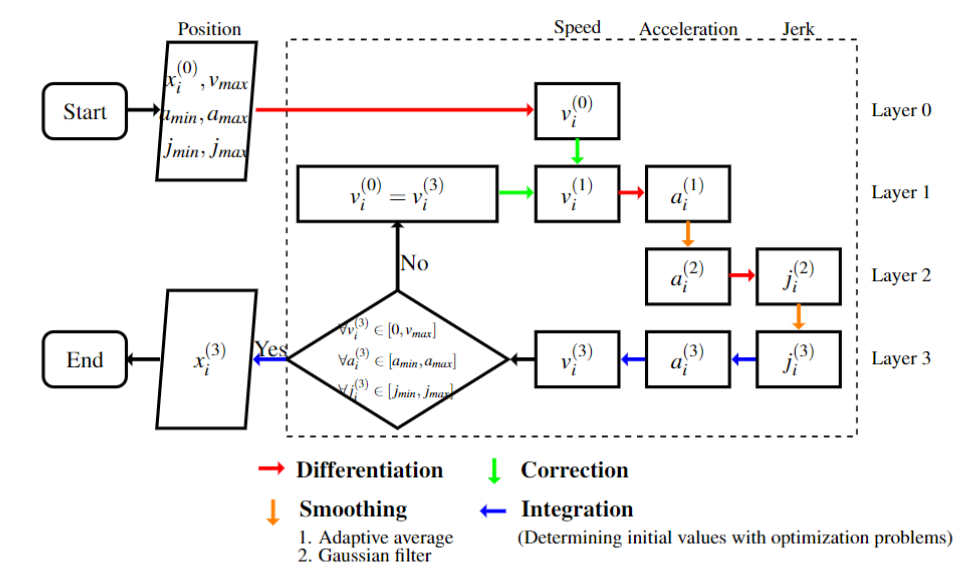

The notation list is as below:

|parameter | remark | parameter | remark |
| :----:| :----: | :----: | :----: |
| $t$ | Time | $T$ | Total recording duration of one vehicle |
| $\Delta t$ | Time step size | $i$ | $=t/\Delta t$, number of the time step |
| $x^{(k)}_i$ | Position at $k_{th}$ layer at time step $i$ | $v^{(k)}_i$ | Speed at $k_{th}$ layer at time step $i$ |
| $a^{(k)}_i$  | Acceleration at $k_{th}$ layer at time step $i$  | $j^{(k)}_i$ | Jerk at $k_{th}$ layer at time step $i$ |
| $\phi_i$ | Gaussian kernel | $\psi_i$ | Gaussian kernel after truncation |
| $r_{a,i}$ | Residual of the acceleration at time step $i$ |  |  |
| $\sigma^{(a)}$ | Inner scale of the Gaussian filter for smoothing the acceleration | $\sigma^{(j)}$ | Inner scale of the Gaussian filter for smoothing the jerk |
| $MAE_{(x)}$ | Mean absolute error of position | $MAE_{(v)}$ | Mean absolute error of speed |
| $MAE_{(a)}$ | Mean absolute error of acceleration |  |  |

## Differentiation of positions
Because the speed and acceleration presented in the original NGSIM dataset are erroneous. The input of our framework is the raw trajectory, and we calculate the raw speed according to the raw velocity. We adopt the symplectic discretization (mixed implicit-explicit Euler discretization) method, which was analytically proved to be the only physically meaningful discretization method that can always lead to collision-free and forward-traveling solutions. We calculate speeds using implicit discretization, accelerations using explicit discretization, and jerks using implicit discretization. The general discretized longitudinal vehicle motion dynamic can be illustrated as follows:

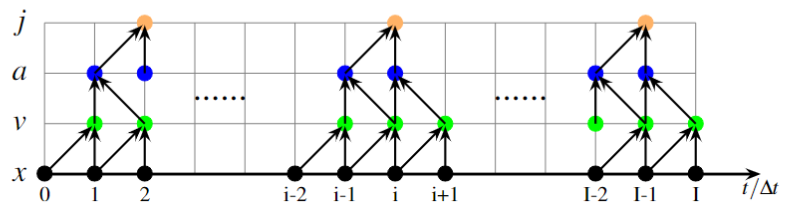

The speed, acceleration, and jerk at each time instant can be calculated as follows:
$$
v^{(k)}_i = \frac{x^{(k)}_i-x^{(k)}_{i-1}}{\Delta t}, \ \ i=1,2,3,......,I, (1a)
$$
$$
a^{(k)}_i = \frac{v^{(k)}_{i+1}-v^{(k)}_{i}}{\Delta t}=\frac{x^{(k)}_{i+1}-2x^{(k)}_{i}+x^{(k)}_{i-1}}{(\Delta t)^2},  \ \ i=1,2,3,......,I-1 (1b)
$$
$$
j^{(k)}_i = \frac{a^{(k)}_{i}-a^{(k)}_{i-1}}{\Delta t}=\frac{x^{(k)}_{i+1} - 3x^{(k)}_{i} + 3x^{(k)}_{i-1} - x^{(k)}_{i-2}}{(\Delta t)^3}, \ \ i=2,3,4,......,I-1 (1c)
$$
Once the four physical quantities are at the same layer, they should satisfy (1a) to (1c). There are $I$ discrete position values in the position profile. The lengths of corresponding speed, acceleration and jerk profiles are $I-1$, $I-2$ and $I-3$, respectively. The speed profile covers $1$ to $I$. The acceleration covers $1$ to $I-1$, while the jerk profile starts at $2$ and ends at $I-1$. All higher-order derivatives at any time instant can be obtained from lower-order derivatives. 

In [ ]:
#veh_cal = veh_complete.values
veh_cal = veh_unit.values
def update_vel(original_array, delta_t):
    import copy
    new_array_np = copy.deepcopy(original_array); cal_array = np.zeros((1,22));
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    for n_id in range(len(id_set)): #go over each vehicle
        new_array = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )] 
        new_array[:,-8] = np.absolute(new_array[:,4] - new_array[0,4]) #moving distance 
        new_array[:,2] = (new_array[:,1] - new_array[0,1]) * 0.1 #time 
        new_array[1:,-7] = (new_array[1:,-8] - new_array[:len(new_array)-1,-8])/delta_t #speed implicit, Eq 1a
        #new_array[1:-1,-6] = (new_array[2:,-7] - new_array[1:-1,-7])/delta_t #acceleration explicit
        #new_array[2:-1,-5] = (new_array[2:-1,-6] - new_array[1:-2,-6])/delta_t #jerk implicit
        
        cal_array = np.vstack((cal_array, new_array));
    return cal_array[1:]

veh_update = update_vel(veh_cal, delta_t = 0.1) #the dataset with original speed and acceleration

The explicit discretization can be written as follows, it can be used to calculate accelerations.

In [ ]:
def differentiate_explicit(lower_order, higher_order, delta_t):
    import copy
    new_array = copy.deepcopy(lower_order);
    update_higher = copy.deepcopy(higher_order);
    update_higher[ : len(new_array)-1] = (new_array[1 : ]-new_array[ : len(new_array)-1]) / delta_t
    
    return update_higher

The implicit discretization can be written as follows, it can be used to calculate speeds and jerks.

In [ ]:
def differentiate_implicit(lower_order, higher_order, delta_t):
    import copy
    new_array = copy.deepcopy(lower_order);
    update_higher = copy.deepcopy(higher_order);
    update_higher[ 1 : ] = (new_array[ 1 : ]-new_array[ : len(new_array)-1]) / delta_t
    
    return update_higher

## Speed correction
The objective of this step is to remove outliers in the speed profile which are generated because of errors in position detection. Let $x^{(0)}_i$ and $v^{(0)}_i$ denote the raw position and the speed calculated from the raw position at time $i$. <br>
We use the adaptive average method to correct the speed profile, in which we average velocities starting at the time when the outlier occurs until such average velocity is within the range. The raw speed values are then replaced by the average speed. <br>
For example, in the figures below, $v^{(0)}_{i+1}$ is negative and needs correction. We add up the speeds starting from $v^{(0)}_{i+1}$ and found that the nearest time point that can lead to a physically feasible average speed is $i+3$. Therefore, we replace the raw speeds in such period with the average speed between $i$ and $i+3$, as illustrated by the red line, and the new positions are shown as the red nodes. Similarly, when a speed exceeds the upper bound, we also replace the raw speeds in such period with the average speed. In both examples, the average speed can be calculated via (2).<br>

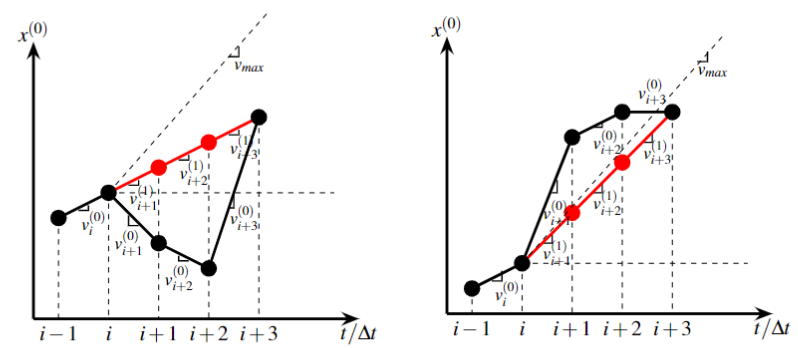

$$
v^{(1)}_{i+1}= v^{(1)}_{i+2}=  v^{(1)}_{i+3} = \frac{v^{(0)}_{i+1}+v^{(0)}_{i+2}+v^{(0)}_{i+3}}{3}. (2)
$$

In [ ]:
def remove_outlier(data, time, up, down, order_id): #raw speed, time instant, the upper boundary and the lower boundary
    import copy
    import matplotlib.pyplot as plt  
    from scipy.interpolate import CubicSpline
    from scipy.interpolate import interp1d
    new_array = copy.deepcopy(data);
    for i in range(len(new_array)): 
        if new_array[i] < down or new_array[i] > up: # the data that is out of the range
            if i <= len(new_array) - 1:        
                for t in range(1,len(new_array)-i): #the points after that points
                    if sum(new_array[i:i+t]/t) >= down and sum(new_array[i:i+t])/t <= up: #the average value in this duration is within range
                        dot_num = t #how many dots in this segment
                        y = [sum(new_array[i:i+t])/t, sum(new_array[i:i+t])/t]; x = [time[i],time[i+t]]
                        sp_curve = interp1d(x, y) #relation between x and y, average speed that replace the original one
                        x_revised = sp_curve(time[i:i+t]) #Eq 2
                        new_array[i:i+t] = x_revised[:]
                        break
            #If the last several points have negative speed values, replace negative values with 0 
            if i >= 0.9 * (len(new_array) - 1):          
                if sum(new_array[i:]) < down or sum(new_array[i:])>= (len(new_array)-i)*up:
                    y = [new_array[i-1], new_array[i-1]]; x = [time[i],time[-1]]
                    sp_curve = interp1d(x, y)
                    x_revised = sp_curve(time[i:])
                    new_array[i:] = x_revised[:]

    return new_array

## Acceleration and jerk smoothing
Here we consider the Gaussian filter, which convolves the input signal with a kernel having the shape of a Gaussian distribution. The Gaussian kernel for smoothing point $i$ can be written as (3): <br>
$$
\phi_i = \frac{1}{\sqrt{2\pi\sigma ^2}}e^{-\frac{(i-i^*)^2}{2\sigma^2}},(3)
$$
where $i^*$ represents the time instant of the target value we want to smooth, $\sigma$ is the standard deviation. However, a true Gaussian response would have infinite impulse responses and it decays rapidly. Therefore, we truncated the Gaussian distribution at some standard derivations, and the truncated Gaussian kernel can be written as: <br>
$$
\psi_i = \frac{\phi_i}{\sum_{\delta=i^*-p\sigma}^{\delta = i^*+p\sigma}\phi_{\delta}},  (4)
$$
where $p$ represents that we smooth the value at $i^*$ with values from $i^*-p\sigma$ to $i^*+p\sigma$.  We choose $p=4$ where the amplitude of the Gaussian function is about $3\times 10^{-4}$ of that at $i^*$, and handle the edge of the signal via zero padding.

In [ ]:
def smooth(data, sigma, T_x, filter_id): # input is the data to be smoothed, one dimentional vector
    import copy, math
    import matplotlib.pyplot as plt  
    from scipy.ndimage import gaussian_filter1d, uniform_filter1d
    delta_t = 0.1 #sec, sampling frequency is 10hz
    array = copy.deepcopy(data);
    if filter_id == 1: #Gaussian filter
        new_data = gaussian_filter1d(array, sigma, mode = 'constant').reshape(len(array),1) #Eq 4
    elif filter_id == 2: #Exponential moving average filter
        window_width = 3*T_x
        array = array.reshape(len(array),1)
        new_data = np.zeros((2*int(3*T_x) + len(array) , 1)); print(np.shape(new_data), np.shape(new_data[int(3*T_x+1) : int(3*T_x+1+len(array))]), "t",int(3*T_x+1+len(array)), len(array))
        new_data[int(3*T_x+1) : int(3*T_x+1+len(array))] = array
        for i in range(int(3*T_x)+1 , int(3*T_x)+len(array)+2):
            Z = 0; X_item = 0
            for k in range(i-int(window_width),i+int(window_width)):#one kernel of smoothing
                Z = Z + math.exp(-abs(i-k)/(T_x))
                X_item = X_item + new_data[k-1]*math.exp(-abs(i-k)/(T_x)) #one time-step has one X_item
            new_data[i-1] = X_item / Z #reconstructed data at i 
        new_data = new_data[int(window_width+1) : int(window_width+1+len(array))]     

    return new_data

## Integration to lower-order derivatives
Considering internal consistency, the acceleration profile should be equal to the integral of the jerk profile, and the acceleration profile should also be integrated to the speed profile. With the entire jerk profile, the acceleration, speed, and position profiles can also be calculated according to (6a)-(6c). The initial state is to be determined when integrating higher-order derivatives to lower-order derivatives.
$$
a^{(k)}_i = a^{(k)}_1+\sum_{\delta=2}^{\delta=i} j^{(k)}_{\delta} \Delta t,\ \ i = 2,3,4, ......,I-1, (6a)
$$
$$
v^{(k)}_i = v^{(k)}_1+\sum_{\delta=1}^{\delta=i} a^{(k)}_{\delta} \Delta t,\ \ i = 1,3,4, ......,I-1, (6b)
$$
$$
x^{(k)}_i = x^{(k)}_1+\sum_{\delta=0}^{\delta=i} v^{(k)}_{\delta} \Delta t, \ \ i = 1,3,4,......,I, (6c)
$$
where $k$ represents the layer, here $k=3$, $I = T/\Delta t$, $T$ denotes the recording duration, $\Delta t$ is the time step size. $a^{(k)}_1$, $v^{(k)}_1$, $x^{(k)}_1$ are the initial states of the acceleration, speed, and position profiles, respectively. 
The calculation is illustrated in Figure 5, with each black node representing
a position, each green node representing a speed, each blue node representing an acceleration, and each yellow node representing a jerk. The arrows' directions indicate the directions of calculations. The calculation can be regarded as an inversed procedure of the differentiation. However, unlike in
differentiation where the entire speed, acceleration, and jerk profiles can be calculated once the position profile is known, the initial values of the acceleration, speed, and position profiles are still unknown when calculating them by integrating the jerk profile, as shown by the hollow nodes.

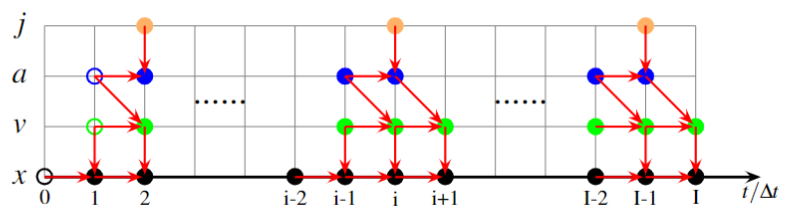

The MAEs between the acceleration and speed profiles before and after integration should also be modest. To obtain the best initial acceleration, we formulate an optimization problem to minimize the MAE between the integral of the jerk profile and the acceleration profile at layer 2 ($a^{(2)}$). We first calculate the residuals of accelerations as follows:

$$
r_{a,i} =  a^{(3)}_i - a^{(2)}_i = a^{(3)}_1+\sum_{\delta=2}^{i} j^{(3)}_{\delta} - a^{(2)}_i, (7)
$$
where $a^{(2)}$ and $j^{(3)}$ are the outputs of `acceleration and jerk smoothing'. Thus, the only unknown variable is $ a^{(3)}_1$. Calculating $ a^{(3)}_1$ can be formulated as a minimization problem minimizing the MAE of the acceleration profile, which is also the mean absolute residual, as follows:
$$
MAE_{(a)}= \frac{1}{I-2}\sum_{i=1}^{I-1} |r_{a,i}|. (8)
$$
Our goal is to find an $a^{(3)}_1$ that minimizes $MAE_{(a)}$ in (8). <br>
order indicator: 1: velocity, implicit 2: acceleration, explicit 3: jerk, implicit <br>

In [ ]:
#order indicator: 1: velocity implicit 2: acceleration explicit 3: jerk implicit
def function_opt(raw_data, cum_high_order, initial_value, delta_t, indicator, opt_ind, order_ind):
    import copy; data_r = copy.deepcopy(raw_data); 
    r_sqr1 = 0;
    r_sqr1 = np.sum( np.absolute(data_r - initial_value - cum_high_order * delta_t)) / len(cum_high_order) #Minimize MAE Eq 7
    #print("order", order_ind, "L1", r_sqr1) # the maximum value of the absolute value of residual
    if opt_ind == 1: #L1 opt
        return r_sqr1 

With $a_1^{(3)}$ calculated from (8), as well as the smoothed jerk profile, we can calculate the entire acceleration profile via (6a). The same for calculating speeds.



In [ ]:
def integrate(higher_order, original_lower, delta_t, indicator, opt_ind, order_ind): #if higher_order is smoothed jerk, then original_lower is differentiated acceleration 
    import copy; import matplotlib.pyplot as plt  
    from scipy.signal import butter,filtfilt,sosfilt; from scipy.ndimage import gaussian_filter1d
    from scipy.optimize import minimize, basinhopping, least_squares, fsolve
    new_lower = copy.deepcopy(original_lower); x0 = np.array((original_lower[0])) #the initial input of the optimization function
    
    #find initial state of lower-order variables
    input_cum = copy.deepcopy(higher_order) #cum higher order, eg: vel[0] + cum(acc[0:t-1]) = vel[t]
    if order_ind == 1 or order_ind == 3: #integrate objective (higher-order) is velocity or jerk
        for i in range(len(higher_order)):
            input_cum[i] = sum(higher_order[:i+1]);
    elif order_ind == 2: #integrate objective (higher-order) is acceleration
        input_cum[0] = 0
        for i in range(1,len(higher_order)):
            input_cum[i] = sum(higher_order[:i]);
    fun = lambda initial_state: function_opt(original_lower, input_cum, initial_state, delta_t, indicator, opt_ind, order_ind); #initial_state, objective variable
    res_a = minimize(fun, x0, method='BFGS'); lower_order_initial = res_a.x; #the final intial value we want to obtain, Eq 8
    
    new_lower[0] = lower_order_initial #change the initial state of the lower order variable profile
    for i in range(1,len(higher_order)): #upddate the integrated lower-order variables
        if order_ind == 1 or order_ind == 3: # acceleration or position
            new_lower[i] = new_lower[i-1] + delta_t * higher_order[i]
        else:  # speed
            new_lower[i] = new_lower[i-1] + delta_t * higher_order[i-1]
    #if opt_ind == 3:
    #    print("order_ind",order_ind, "optimize initial", res_a.x, new_lower[1])

    return new_lower

After obtaining the entire acceleration profile, the same procedure can be applied to the speed profile. Similarly, the objective is to find out $v^{(3)}_1$ which leads to the minimum $MAE_{(v)}$ between the integral of $a^{(3)}$ and $v^{(1)}$.
At this point, we check whether all speeds, accelerations and jerks are physically feasible. If there are still outliers, as our framework shows, we take the current speed profile as the new $v^{(0)}$ and conduct another iteration with smaller standard derivations in the Gaussian filter to fine-tune the results.

When all speeds, accelerations, and jerks are physically feasible, we consider that we have completed all the calculations in the dashed black box in the framework, and we can calculate the ultimate output of our method. We integrate the speed profile back to the position profile according to (6c), and calculate the initial position that leads to the smallest $MAE_{(x)}$. So far, the reconstructed vehicle trajectory is obtained.


In [ ]:
def iteration1(data, sigma_a, sigma_j, T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt, correct, filters): # the input is a matrix including the information of all variables
    import copy; import matplotlib.pyplot as plt  
    from scipy.signal import butter,filtfilt,sosfilt; from scipy.ndimage import gaussian_filter1d
    from scipy.optimize import minimize, basinhopping, least_squares, fsolve
    array = copy.deepcopy(data); new_array_np = copy.deepcopy(data); cal_array = np.zeros((1,22)); cal_array1 = np.zeros((1,22)) #to instore the raw data
    id_set = sorted(set(array[:,0].tolist()),key = array[:,0].tolist().index)#pick out all the ids, and create a list to store them
    '''
    In one iteration, we go through the calculations mentioned before.
    '''
    for n_id in range(len(id_set)): #go over each vehicle
        update_array = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )]; i = 0
        if correct == 1: #Step 1: adaptive average method
            update_array[1:,-7] = remove_outlier(array[:,-7], array[:,2], up_v, down_v, 1)[1:] #remove outlier of speed
        update_array[1:-1,-6] = differentiate_explicit(update_array[:,-7], array[:,-6], delta_t)[1:-1]; array[1:-1,-6] = copy.deepcopy(update_array[1:-1,-6]) #differentiated acceleration
        
        if (np.round(update_array[1:-1,-6],3) >= up_a).any() or (np.round(update_array[1:-1,-6],3) <= down_a).any(): #if there are out-range acceleration: step 2: smooth acceleration
            update_array[1:-1,-6] = smooth(update_array[1:-1,-6], sigma_a, T_a, filters)[:,0] #smoothed acceleration
        else:
            update_array[1:-1,-6] = update_array[1:-1,-6]
        update_array[2:-1,-5] = differentiate_implicit(update_array[:,-6], array[:,-5], delta_t)[2:-1] #differentiate to jerk
        if (abs(np.round(update_array[2:-1,-5],3)) >= up_j).any(): #if there are out-range jerk values: smooth jerk
            update_array[2:-1,-1] = smooth(update_array[2:-1,-5], sigma_j, T_j, filters)[:,0] #smoothed jerk
        else:
            update_array[2:-1,-1] = update_array[2:-1,-5]
        update_array[1:-1,-2] = integrate(update_array[1:-1,-1], update_array[1:-1,-6], delta_t, 1, opt, 3) #integrated acceleration, step 3: adjust the initial state
        update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #integrated speed
        #print("id",data[0,0],"i",0,"-----------------------------------------------------------------------------")
        #If after one interation, there are still outliers, we need to repeat the process before. 
        while i < 200: #the upper bounds of the iterations
            i = i+1
            if (np.round(update_array[1:,-3],3) < down_v).any() or (np.round(update_array[1:,],3) > up_v).any(): #if there is any negative speed   
                update_array[1:,-3] = remove_outlier(update_array[:,-3], array[:,2], up_v, down_v, 1)[1:] #speed
                update_array[1:-1,-2] = differentiate_explicit(update_array[:,-3], array[:,-6], delta_t)[1:-1] #acceleration
                update_array[2:-1,-1] = differentiate_implicit(update_array[:,-2], array[:,-5], delta_t)[2:-1] #jerk
            if (np.round(update_array[2:-1,-2],3) >= up_a).any() or (np.round(update_array[2:-1,-2],3) <= down_a).any(): #if there are still out-range acceleration
                update_array[1:-1,-2] = smooth(update_array[1:-1,-2], 1, 0.1, filters)[:,0] #acceleration
                update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #speed
                update_array[2:-1,-1] = differentiate_implicit(update_array[:,-2], array[:,-5], delta_t)[2:-1] #jerk               
            if (abs(np.round(update_array[2:-1,-1],3)) >= up_j).any(): #if there are still out-range jerk
                update_array[2:-1,-1] = smooth(update_array[2:-1,-1], 1, 0.1, filters)[:,0] #jerk
                update_array[1:-1,-2] = integrate(update_array[1:-1,-1], update_array[1:-1,-6], delta_t, 1, opt, 3) #acceleration
                update_array[1:,-3] = integrate(update_array[1:,-2], update_array[1:,-7], delta_t, 2, opt, 2) #speed               
            if (abs(np.round(update_array[2:-1,-1],3)) <= up_j).all() and (np.round(update_array[1:,-3],3) >= down_v).all() and (abs(np.round(update_array[1:,-3],3)) < up_v).all() and (np.round(update_array[1:-1,-2],3) <= up_a).all() and (np.round(update_array[1:-1,-2],3) >= down_a).all():
                #print("over")
                break
            #print("id",update_array[0,0],"i",i,"-----------------------------------------------------------------------------")
        update_array[:,-4] = integrate(update_array[:,-3], array[:,-8], delta_t, 3, opt, 1) #integrated position
        update_array = update_array[2:-1]
        cal_array = np.vstack((cal_array, update_array)); cal_array1 = np.vstack((cal_array1, array[2:-1]))
        #Calculate the position MAE
        position_error_vec = cal_array[:,-4] - cal_array[:,-8]; position_error = sum([abs(x) if x <= 0 else x for x in position_error_vec])/len(position_error_vec); #print("pos err", position_error) 

    return cal_array[1:], cal_array1[1:], position_error_vec

# Choice of method and parameters
The parameters that need careful tuning are the standard derivations in the Gaussian filter for smoothing accelerations and jerks ($\sigma^{(a)}$ and $\sigma^{(j)}$). If we choose too small $\sigma^{(a)}$ and $\sigma^{(j)}$, the method will go through a large number of iterations, which significantly increases the computation cost and may also result in an increase in position errors following numerous integral calculations; on the other hand, if we choose too large standard derivations, the method can be completed in a single iteration, but the local information in the raw data may be overlooked. Except for the first iteration, the subsequent iterations are mainly used to fine-tune the values if the speed, acceleration, or jerk profiles still contain outliers after the first iteration. Therefore, we set both $\sigma^{(a)}$ and $\sigma^{(j)}$ to be 1 time-step in the subsequent iterations, and we will further discuss the parameter settings in the first iteration.

As pointed out by P3, the MAE in the raw positions should be kept to a minimum. To determine the best combination of $\sigma^{(a)}$ and $\sigma^{(j)}$, we choose the MAE between the raw and the reconstructed positions as the evaluation metric, and it can be calculated as follows:  
$$
MAE^{(\sigma^{(a)}, \sigma^{(j)})}_{(x)} = \frac{\sum_{i=0}^{I}|x^{(0)}_i-x^{(3)}_i|}{I}, (9)
$$
where $I=T/\Delta t$ and $T$ is the recording duration. Based on this, we develop an algorithm to determine $\sigma^{(a)}$ and $\sigma^{(j)}$. The flow chart of the algorithm is shown below, and detailed processes will follow. <br>

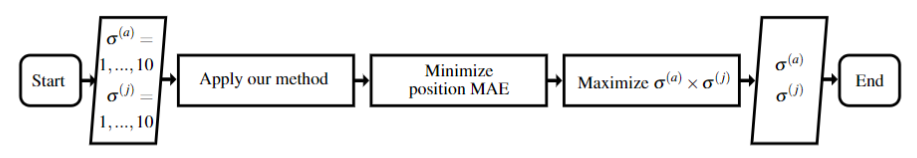




1. Investigate $\sigma^{(a)}$ and $\sigma^{(j)}$ values ranging from 1 to 10 time-steps at 1 time-step intervals (100 combinations), apply our method, and calculate the corresponding MAEs between the raw and the reconstructed positions. This step returns 100 MAE values.
2. Pick out all the combinations of $\sigma^{(a)}$ and $\sigma^{(j)}$ which can satisfy $\Delta MAE_{(x)} < 10^{-3}m$ as candidate parameter combinations, where $\Delta MAE_{(x)} = |MAE^{(\sigma^{(a)}, \sigma^{(j)})}_{(x)}-\min (MAE_{(x)})|$ and $\min (MAE_{(x)})$ is the minimum MAE among the 100 values. 
3. Among the candidate parameter combinations, choose the one with the largest $\sigma^{(a)} \cdot \sigma^{(j)}$. If two combinations lead to the same $\sigma^{(a)} \cdot \sigma^{(j)}$, choose the one with the larger $\sigma^{(a)} $. 

In [ ]:
def dectect_window(data, up_wj, low_wj, up_wa, low_wa, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, T_a, T_j, opt_id, correct, filters):
    import copy;
    input_data = copy.deepcopy(data) #raw matrix of one vehicle
    error_cum = np.zeros((up_wj-low_wj,up_wa-low_wa)) #to store the cummulative error under different window sizes
    id_set = sorted(set(input_data[:,0].tolist()),key = input_data[:,0].tolist().index)#pick out all the ids, and create a list to store them
    for i in range(low_wj, up_wj): #smoothing window for jerk
        for k in range(low_wa, up_wa): #smoothing window for acceleration
            for n_id in range(len(id_set)): #go over each vehicle
                sub_veh = input_data[np.where(input_data[:,0] == id_set[n_id] )] #extract vehicle matrix according to vehicle id
                modify_traj, raw_traj, pos_err = iteration1(sub_veh, k, i, T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt_id, correct, filters) #trajectories after several iterations
                position_error = modify_traj[:,-4] - modify_traj[:,-8] # difference between modified trajectory and raw position
                position_error = [abs(x) if x <= 0 else x for x in position_error] 
                error_cum[i-low_wj,k-low_wa] += sum(position_error)/len(position_error) 
                #print("i=",i,"k=",k,"n_id",id_set[n_id], "error=",error_cum[i-low_wj,k-low_wa])
    error_ave = error_cum / len(id_set) #Eq (10)
    candidate_com = np.array(np.where(abs(np.round(error_ave,3) - round(np.min(error_ave),3)) < 0.001)) # step 2 in closed-loop method, pick out all cadidate combinations 
    #"candidate_com" includes the indexes of the cadidate combinations
    index = np.argmax((candidate_com[0,:]+1)*(candidate_com[1,:]+1)) # step 3 in the closed-loop method, candidate_com[0,index]+1 is sigma_j and candidate_com[1,index]+1 is sigma_a
    sigma_pair = [candidate_com[1,index]+1, candidate_com[0,index]+1]
    print("error_cum",error_ave, "candidate combination", candidate_com, "sigma pair:", sigma_pair)
    return error_ave, sigma_pair


# Application to NGSIM dataset




## Choice of the parameter combination

In [ ]:
delta_t = 0.1; up_v = 20; down_v = 0; up_a = 4; down_a = -5; up_j = 15; down_j = -15; opt_id = 1; correct_ite = 1; correct_ada = 1; filter_gau = 1; 
up_wj = 11; low_wj=1; up_wa = 11; low_wa=1; opt_id = 1; correct_ite = 2; correct_ada = 1; T_a = 0; T_j = 0

error_pos, sigma = dectect_window(veh_update, up_wj, low_wj, up_wa, low_wa, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, T_a, T_j, opt_id, correct_ada, filter_gau)

error_cum [[0.19  0.19  0.194 0.19  0.191 0.192 0.224 0.27  0.319 0.373]
 [0.19  0.19  0.193 0.19  0.191 0.192 0.224 0.27  0.319 0.373]
 [0.19  0.19  0.195 0.19  0.191 0.192 0.224 0.27  0.319 0.373]
 [0.191 0.191 0.195 0.193 0.197 0.192 0.224 0.27  0.319 0.373]
 [0.192 0.192 0.193 0.201 0.226 0.192 0.224 0.27  0.319 0.373]
 [0.194 0.231 0.235 0.237 0.263 0.192 0.224 0.27  0.319 0.373]
 [0.237 0.341 0.303 0.274 0.301 0.192 0.224 0.27  0.319 0.373]
 [0.284 0.399 0.324 0.317 0.344 0.192 0.224 0.27  0.319 0.373]
 [0.688 0.463 0.359 0.366 0.391 0.192 0.224 0.27  0.319 0.373]
 [0.711 0.498 0.408 0.418 0.442 0.192 0.224 0.27  0.319 0.373]] candidate combination [[0 0 0 1 1 1 2 2 2]
 [0 1 3 0 1 3 0 1 3]] sigma pair: [4, 3]


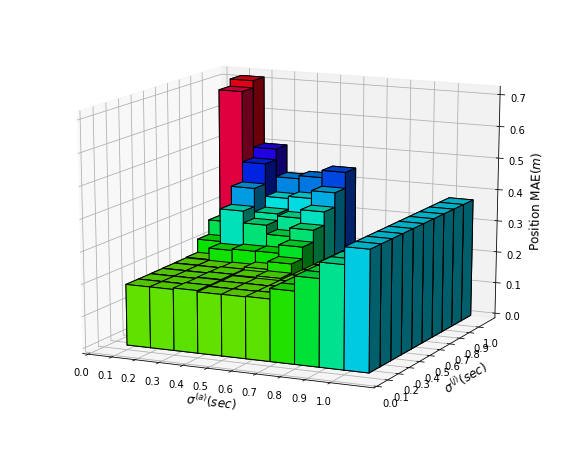

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

size=error_pos.shape
Y=np.arange(0.1,size[0]*0.1+0.1,0.1)     
X=np.arange(0.1,size[1]*0.1+0.1,0.1)

X,Y=np.meshgrid(X,Y)  
x,y = X.ravel(), Y.ravel() #ravel 
top=[]
for i in range(10):
    for j in range(10):
        top.append(error_pos[i][j])
bottom = np.zeros_like(top)#starting point of each bar
width = depth = 0.1 #width of each bar
fig=plt.figure(figsize=(10,8))

ax=fig.gca(projection='3d') 
surf = ax.bar3d(x,y, bottom, width, depth, top, shade=True, color=plt.cm.hsv(np.array(top).flatten()/float(np.array(top).max())), edgecolor="black" )
ax.set_xlabel("$\sigma^{(a)}$($sec$)",fontdict={'family' : 'DejaVu Sans', 'size': 12})
ax.set_ylabel("$\sigma^{(j)}$($sec$)",fontdict={'family' : 'DejaVu Sans', 'size': 12})
ax.set_zlabel("Position MAE($m$)",fontdict={'family' : 'DejaVu Sans', 'size': 12})
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],size = 10)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],size = 10)
# Add a color bar which maps values to colors.
ax.view_init(elev=15, azim=-65)
plt.show()

## Processed trajectory




In [ ]:
id_set = sorted(set(veh_cal[:,0].tolist()),key = veh_cal[:,0].tolist().index)

sigma_j = sigma[1]; sigma_a = sigma[0]; T_a = 2; T_j = 10; delta_t = 0.1; up_v = 20; down_v = 0; up_a = 4; down_a = -5; up_j = 15; down_j = -15; opt_id = 1; correct_ite = 1; correct_ada = 1
filter_gau = 1; filter_mov = 2
smooth_veh1, raw_veh1, smooth_pos_err = iteration1(veh_update, sigma_a, sigma_j, T_a, T_j, delta_t, up_v, down_v, up_a, down_a, up_j, down_j, opt_id, correct_ada, filter_gau)

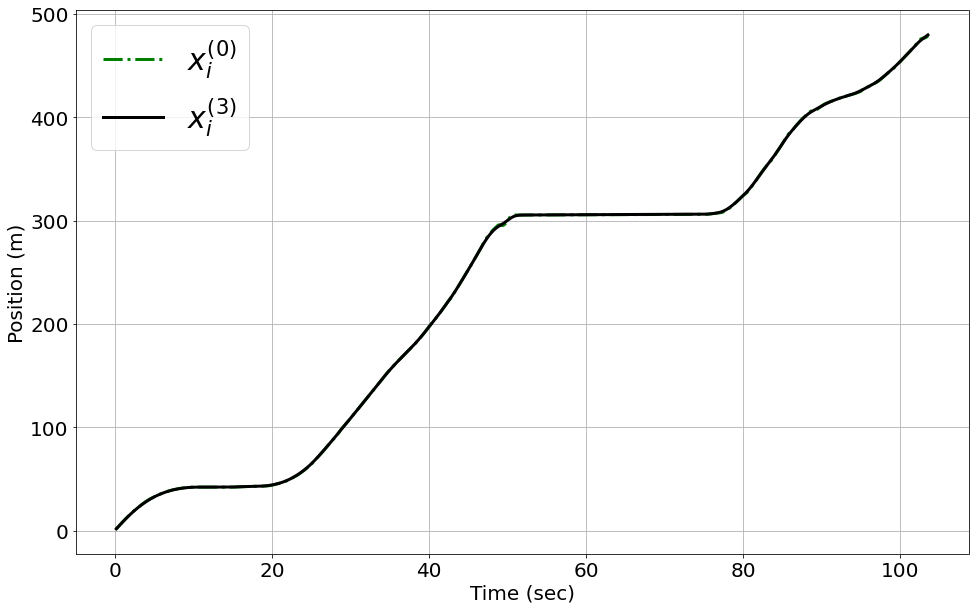

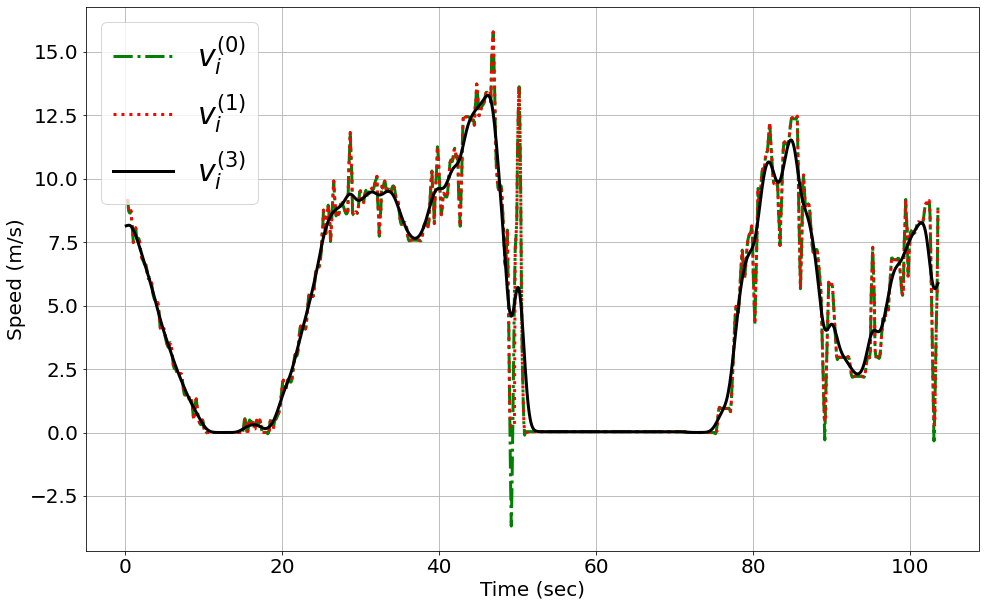

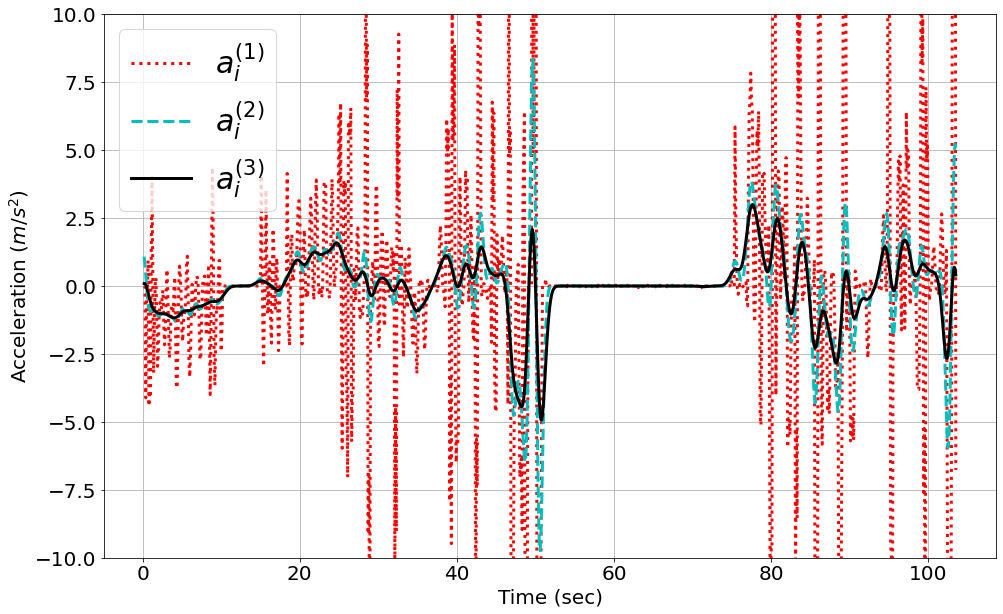

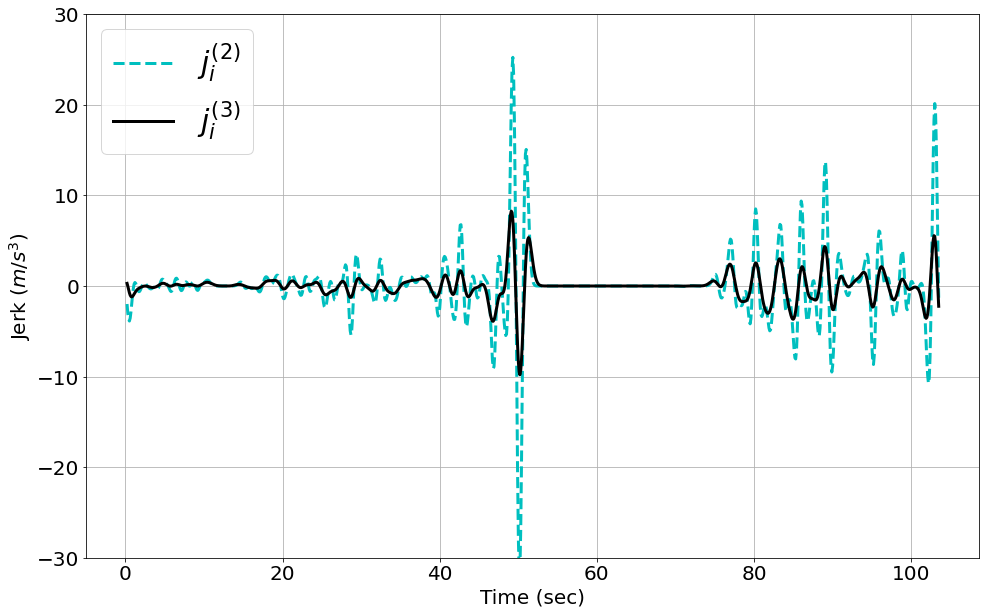

In [ ]:
id = 0
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10));
plt.tick_params(labelsize=20)
plt.figure(1)
plt.ylabel("Position (m)", fontsize=20); plt.xlabel("Time (sec)", fontsize=20)
plt.plot(veh_update[np.where(veh_update[:,0] == id_set[id])][2:-1,2],veh_update[np.where(veh_update[:,0] == id_set[id])][2:-1,-8], color = "g", linewidth=3, linestyle='-.', label = "$x^{(0)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-4], color = "k", linewidth=3, label = "$x^{(3)}_i$");
plt.grid(); plt.legend(fontsize=30, loc = 2)

plt.figure(figsize=(16,10)); 
plt.tick_params(labelsize=20)
plt.figure(2)
plt.ylabel("Speed (m/s)", fontsize=20); plt.xlabel("Time (sec)", fontsize=20)
plt.plot(veh_update[np.where(veh_update[:,0] == id_set[id])][2:-1,2],veh_update[np.where(veh_update[:,0] == id_set[id])][2:-1,-7], color = "g", linewidth=3, linestyle='-.', label = "$v^{(0)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-7], color = "r", linewidth=3, linestyle=':', label = "$v^{(1)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-3], color = "k", linewidth=3, label = "$v^{(3)}_i$");
plt.grid(); plt.legend(fontsize=30, loc = 2)

plt.figure(figsize=(16,10)); plt.ylim(-10,10)
plt.tick_params(labelsize=20)
plt.figure(3)
plt.ylabel("Acceleration ($m/s^2$)", fontsize=20); plt.xlabel("Time (sec)", fontsize=20)
plt.plot(raw_veh1[:,2],raw_veh1[:,-6], color = "r", linewidth=3, linestyle=':', label = "$a^{(1)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-6], color = "c", linewidth=3, linestyle='--', label = "$a^{(2)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-2], color = "k", linewidth=3, label = "$a^{(3)}_i$");
plt.grid(); plt.legend(fontsize=30, loc = 2)

plt.figure(figsize=(16,10)); plt.ylim(-30,30)
plt.tick_params(labelsize=20)
plt.figure(4)
plt.ylabel("Jerk ($m/s^3$)", fontsize=20); plt.xlabel("Time (sec)", fontsize=20)
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-5], color = "c", linewidth=3, linestyle='--', label = "$j^{(2)}_i$"); 
plt.plot(smooth_veh1[:,2],smooth_veh1[:,-1], color = "k", linewidth=3, label = "$j^{(3)}_i$");
plt.grid(); plt.legend(fontsize=30, loc = 2)

## Frequency spectrum

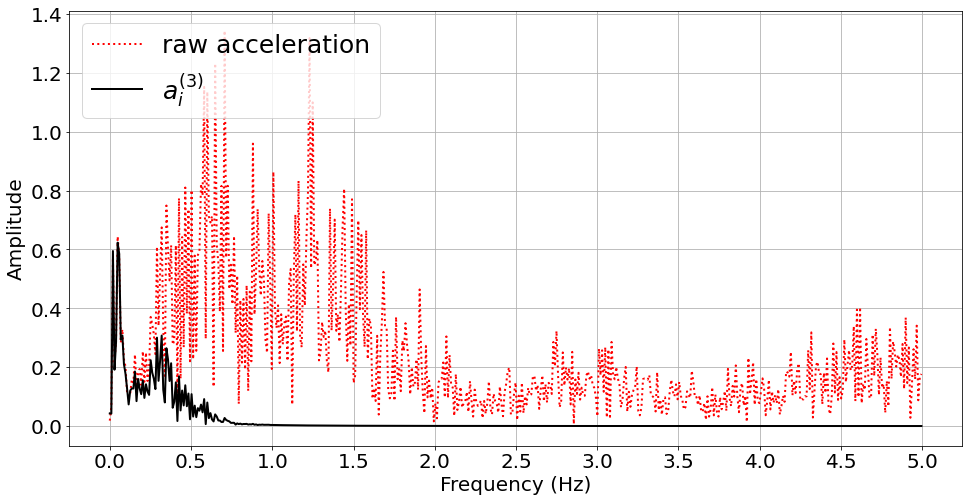

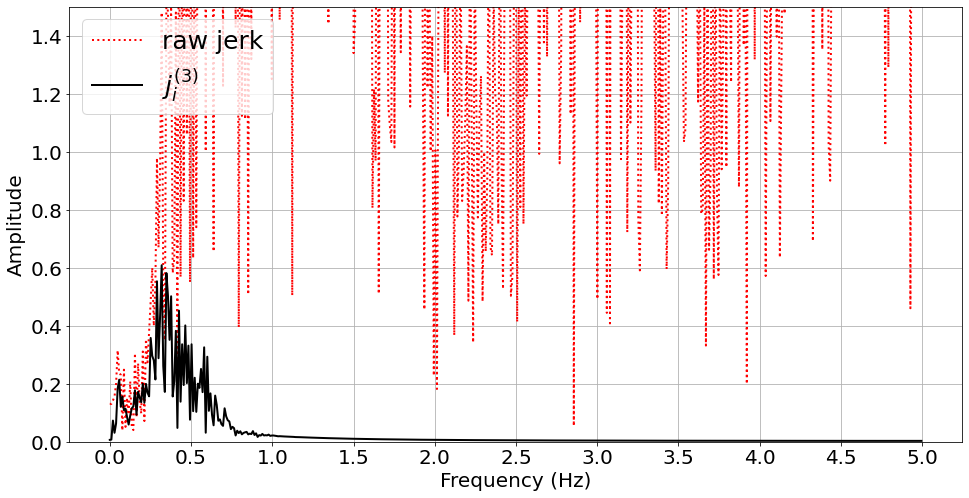

In [ ]:
def displaySpectrum_smooth(data_raw, data_smooth):
    import copy; from scipy.fftpack import fft
    from scipy import fftpack, arange; import matplotlib.pyplot as plt
    from pylab import plot, show, title, xlabel, ylabel, subplot
    N = len(data_raw); duration = N*0.1; dt = 0.1 #duration and sampling step(s)
    fs = 1/dt; #sampling frequency
    data_raw[:len(data_raw)-1,-6] = (data_raw[1:,-7] - data_raw[:len(data_raw)-1,-7])/0.1 #acceleration explicit
    data_raw[1:,-5] = (data_raw[1:,-6] - data_raw[:len(data_raw)-1,-6])/0.1 #jerk implicit

    series_raw = copy.deepcopy(data_raw); series_smooth = copy.deepcopy(data_smooth); 
    hat_v_hz = fft(series_smooth[:,-7],N); hat_a_hz = fft(series_raw[:,-6],N); hat_j_hz = fft(series_raw[:,-5],N); #Fourier transform
    tilde_a_hz = fft(series_smooth[:,-6],N); tilde_j_hz = fft(series_smooth[:,-5],N)
    tilde2_j_hz = fft(series_smooth[:,-1],N); tilde2_a_hz = fft(series_smooth[:,-2],N); 
    frq = np.linspace(0, fs, N)
    mag_hat_a = 2*(np.absolute(hat_a_hz))/N; mag_tilde_a = 2*(np.absolute(tilde_a_hz))/N; mag_tilde_a2= 2*(np.absolute(tilde2_a_hz))/N; 
    mag_hat_j = 2*(np.absolute(hat_j_hz))/N; mag_tilde_j = 2*(np.absolute(tilde_j_hz))/N; mag_tilde_j2= 2*(np.absolute(tilde2_j_hz))/N; 
    
    font2 = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 20,}; font1 = 25

    plt.figure(figsize=(16,8)); plt.xticks(np.arange(0, 5.5, 0.5),fontsize=20); plt.yticks(fontsize=20) #plt.xlim(0,100)
    plt.figure(1)
    plt.ylabel("Amplitude", font2); plt.xlabel("Frequency (Hz)", font2)
    plt.plot(frq[:len(frq) // 2],mag_hat_a[:len(frq) // 2], color = "r", linewidth=2, linestyle=':', label = "raw acceleration");
    plt.plot(frq[:len(frq) // 2],mag_tilde_a2[:len(frq) // 2], color = "k", linewidth=2, label = "$a^{(3)}_i$"); 
    plt.grid(); plt.legend(fontsize=25, loc = 2)

    plt.figure(figsize=(16,8)); plt.xticks(np.arange(0, 5.5, 0.5),fontsize=20); plt.yticks(fontsize=20); plt.ylim(0,1.5); 
    plt.figure(2)
    plt.ylabel("Amplitude", font2); plt.xlabel("Frequency (Hz)", font2)
    plt.plot(frq[:len(frq) // 2],mag_hat_j[:len(frq) // 2], color = "r", linewidth=2, linestyle=':', label = "raw jerk");
    plt.plot(frq[:len(frq) // 2],mag_tilde_j2[:len(frq) // 2], color = "k", linewidth=2, label = "$j^{(3)}_i$");  
    plt.grid(); plt.legend(fontsize=25, loc = 2)

displaySpectrum_smooth(raw_veh1, smooth_veh1)

## Position MAE distribution

mean pos 0.008882540085809236
norm: mu 0.008882540085809236 std 0.33716459374628255 ks KstestResult(statistic=0.165501351260616, pvalue=3.2058781199304237e-25)
cauchy: mu 0.010887581975106805 std 0.08501144068036591 ks KstestResult(statistic=0.3330724391473704, pvalue=9.440827683866897e-103)
gamma: alpha 348.38035963411994 loc -6.586229300761804 ks KstestResult(statistic=0.17317030777233466, pvalue=1.3838457786333993e-27)


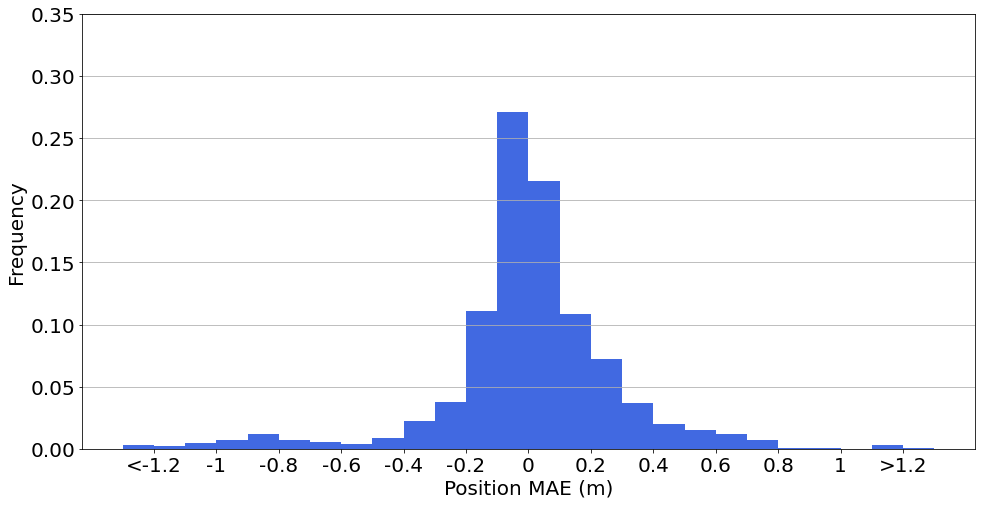

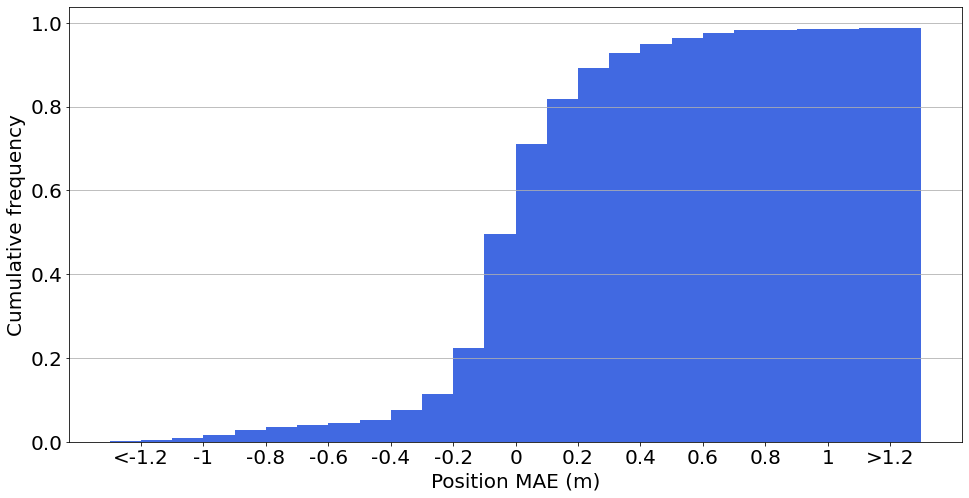

In [ ]:
def pos_mae(data): #the input is the processed data
    import copy, numpy; import matplotlib.pyplot as plt; import matplotlib; from scipy.stats import norm, cauchy, chi2, kstest, gamma   
    new_array = copy.deepcopy(data)
    raw_pos = new_array[:,-8]; new_pos = new_array[:,-4]; pos_mae = new_pos - raw_pos; print("mean pos",np.mean(pos_mae))
    bin = np.linspace(-1.3, 1.3, 27)
    font2 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 20,}; font1 = 25

    plt.figure(figsize=(16,8)); plt.figure(1); plt.ylim(0,0.35)
    plt.xticks(np.arange(-1.2, 1.4, 0.2), ["<-1.2","-1","-0.8","-0.6","-0.4","-0.2","0","0.2","0.4","0.6","0.8","1",">1.2"], fontsize=20); plt.yticks(fontsize=20)
    plt.xlabel("Position MAE (m)", font2); plt.ylabel("Frequency", font2)
    plt.hist(pos_mae, bins=bin, color= 'royalblue', weights=[1/len(pos_mae)]*len(pos_mae)); 
    plt.show; plt.grid(axis="y");

    x = np.arange(-1.2, 1.2, 1/len(pos_mae)); mu_norm, std_norm = norm.fit(pos_mae); norm_curve = norm.pdf(x, mu_norm, std_norm) #fit the data with the normal distribution
    mu_c, std_c = cauchy.fit(pos_mae);   cauchy_curve = norm.pdf(x, mu_c, std_c) #fit with cauchy distribution
    fit_alpha, fit_loc, fit_beta = gamma.fit(pos_mae); gamma_curve = gamma.pdf(x, fit_alpha, fit_loc, fit_beta) #fit with gamma distribution
    #normal fit
    pos_mae1 = (pos_mae - mu_norm) / std_norm
    ks_norm = kstest(pos_mae1, "norm") #Kolmogorov-Smirnov test
    print("norm:" , "mu", mu_norm, "std", std_norm, "ks", ks_norm)
    #cauchy fit
    ks_cauchy = kstest(pos_mae, "cauchy") #Kolmogorov-Smirnov test
    print("cauchy:" , "mu", mu_c, "std", std_c, "ks", ks_cauchy)
    #gamma fit
    ks_gamma = kstest(pos_mae, "gamma", args=(fit_alpha, fit_loc, fit_beta)) #Kolmogorov-Smirnov test
    print("gamma:" , "alpha", fit_alpha, "loc", fit_loc, "ks", ks_gamma)
    #print(len(pos_mae), p_norm, std_norm, p_cauchy, p_gamma) 

    #cumulative distribution
    plt.figure(figsize=(16,8)); plt.figure(2)
    plt.xticks(np.arange(-1.2, 1.4, 0.2), ["<-1.2","-1","-0.8","-0.6","-0.4","-0.2","0","0.2","0.4","0.6","0.8","1",">1.2"], fontsize=20); plt.yticks(fontsize=20)
    plt.xlabel("Position MAE (m)", font2); plt.ylabel("Cumulative frequency", font2)
    plt.hist(pos_mae, bins=bin, color= 'royalblue', cumulative = True, weights=[1/len(pos_mae)]*len(pos_mae))
    plt.show; plt.grid(axis="y")

pos_mae(smooth_veh1)

# Print out data

In [ ]:
from google.colab import files
pd.DataFrame(smooth_veh1).to_csv('processed_traj.csv') 
files.download('processed_traj.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>